In [49]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from glob import glob
from scipy.signal import resample,savgol_filter
import math
from numpy.fft import * 

In [7]:
datadir = "/home/doshna/Documents/PHD/data/fatties/"
stims = glob(datadir+"*/*.csv")

In [8]:
spath = stims[2]
stim = pd.read_csv(spath)
start = np.array(stim["Time"])[-1] -60 ## last 60 seconds are what we want to sync with MP 

tst = stim[stim["Time"]>=start] ## The true stim df 


In [38]:
fs_orig = math.floor(tst.shape[0]/60)
fs = 1000 
target_samples = int(np.floor(60 * fs)) 
ds_stim = resample(stim["Position"],target_samples)
ds_time = np.linspace(0,60.,target_samples)

In [39]:
def for_range(signal, fs,freq_range):
    N = len(signal)
    fr = fftfreq(N,1/fs)
    fft_sig = fft(signal)

    freq_indices = np.where((fr >= freq_range[0]) & (fr <= freq_range[1]))

    fft_range = np.abs(fft_sig[freq_indices])
    freq_range = fr[freq_indices]

    return(fft_range,freq_range)

In [42]:
f,t = for_range(ds_stim[0:20000],1000,[0,20])

In [47]:
freqs = np.array([0.2000,0.3000,0.5000,0.7000,1.100,1.300,1.700,1.900,2.300,2.900,3.700,4.300,5.300,6.100,7.900,8.900,11.30,13.70,16.70 ,19.90]
)

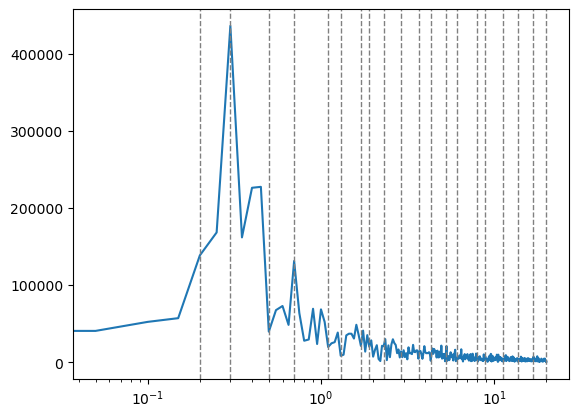

In [48]:
plt.semilogx(t,f)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)

In [69]:
sg = savgol_filter(ds_stim,51,3)
sgv = savgol_filter(ds_stim,51,3,deriv=1)


In [70]:
sgm,sgf = for_range(sg[0:20000],1000,[0,20])
sgvm, sgvf = for_range(sgv[0:20000],1000,[0,20])

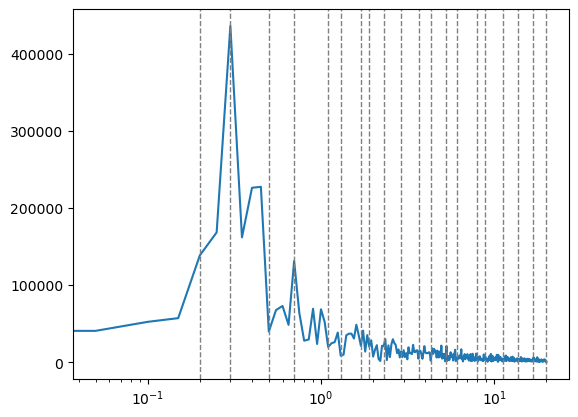

In [71]:
plt.semilogx(sgf,sgm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)

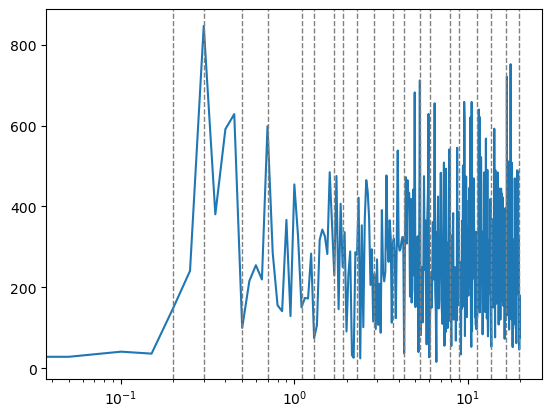

In [68]:
plt.semilogx(sgvf,sgvm)
for p in freqs:
    plt.axvline(x = p,color="gray",linestyle="--",linewidth=1)